In [1]:
import numpy as np
import scipy as sp
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  


In [2]:
#load data
industry_portfolio_df = pd.read_excel('Industry_Portfolios.xlsx')
market_portfolio_df = pd.read_excel('Market_Portfolio.xlsx')
risk_factors_df = pd.read_excel('Risk_Factors.xlsx')
industry_portfolio_df

/home/kilo/.local/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/kilo/.local/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/kilo/.local/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Date,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
0,200401,0.06,-1.07,-0.62,0.44,4.53,1.41,0.45,3.09,1.92,2.88
1,200402,4.25,-0.07,1.95,4.69,-2.92,-0.52,6.09,0.89,2.07,2.16
2,200403,-0.09,-1.15,-0.27,-0.13,-2.55,-2.07,0.29,-3.96,1.13,-0.63
3,200404,1.42,2.30,-0.17,2.52,-4.91,-0.48,-2.70,3.54,-3.55,-3.76
4,200405,-1.89,-1.64,1.61,0.39,4.85,-2.95,0.30,-0.42,1.28,1.86
...,...,...,...,...,...,...,...,...,...,...,...
115,201308,-4.00,-1.00,-1.95,-1.83,-0.12,-3.28,-4.21,-3.49,-4.43,-3.66
116,201309,1.94,6.46,5.20,2.03,3.77,4.33,4.46,4.19,1.05,3.83
117,201310,4.75,0.72,4.56,4.86,3.80,5.52,5.08,3.47,3.35,3.87
118,201311,1.29,1.81,2.95,0.85,3.65,0.27,3.67,4.54,-1.81,4.74


In [3]:
# use merge for join inner i guess
concated_df = industry_portfolio_df\
            .merge(market_portfolio_df, on ='Date', how='inner')
concated_df = concated_df\
            .merge(risk_factors_df, on ='Date', how='inner')
portfolio_cols = concated_df.columns[1:11]
marketexcess_risk_df  = pd.DataFrame()
for x in portfolio_cols:
    marketexcess_risk_df[f'{x}_marketexcess']=concated_df[x] - concated_df['Market']
#excess_risk_df
marketexcess_cols = marketexcess_risk_df.columns
concated_df = pd.concat([concated_df, marketexcess_risk_df], axis=1 )

In [4]:
marketexcess_risk_df

,NoDur_marketexcess,Durbl_marketexcess,Manuf_marketexcess,Enrgy_marketexcess,HiTec_marketexcess,Telcm_marketexcess,Shops_marketexcess,Hlth_marketexcess,Utils_marketexcess,Other_marketexcess
0,-2.16,-3.29,-2.84,-1.78,2.31,-0.81,-1.77,0.87,-0.30,0.66
1,2.79,-1.53,0.49,3.23,-4.38,-1.98,4.63,-0.57,0.61,0.70
2,1.14,0.08,0.96,1.10,-1.32,-0.84,1.52,-2.73,2.36,0.60
3,3.17,4.05,1.58,4.27,-3.16,1.27,-0.95,5.29,-1.80,-2.01
4,-3.12,-2.87,0.38,-0.84,3.62,-4.18,-0.93,-1.65,0.05,0.63
...,...,...,...,...,...,...,...,...,...,...
115,-1.31,1.69,0.74,0.86,2.57,-0.59,-1.52,-0.80,-1.74,-0.97
116,-1.82,2.70,1.44,-1.73,0.01,0.57,0.70,0.43,-2.71,0.07
117,0.58,-3.45,0.39,0.69,-0.37,1.35,0.91,-0.70,-0.82,-0.30
118,-1.83,-1.31,-0.17,-2.27,0.53,-2.85,0.55,1.42,-4.93,1.62


In [5]:
R = marketexcess_risk_df.mean().to_numpy()
V = marketexcess_risk_df.cov().to_numpy()
stdev = marketexcess_risk_df.std()

In [6]:
resultdf = pd.concat([marketexcess_risk_df.mean(),marketexcess_risk_df.std()],axis=1).rename(columns = {0:'mean',1:'std dev'})
resultdf

,mean,std dev
NoDur_marketexcess,0.154750,2.332316
Durbl_marketexcess,-0.014750,5.160320
Manuf_marketexcess,0.264750,1.717702
Enrgy_marketexcess,0.483083,4.390320
HiTec_marketexcess,0.018167,2.258040
Telcm_marketexcess,0.133333,2.163924
Shops_marketexcess,0.168250,2.110125
Hlth_marketexcess,0.035750,2.796506
Utils_marketexcess,0.159083,3.502496
Other_marketexcess,-0.259000,2.122075


In [7]:
class mva():
    def __init__ (self,R,V):
        self.R = R #mean
        self.V = V #covariance matrix
        self.size =\
            len(self.R)
        self.V_inv =\
            np.linalg.inv(self.V)
        self.alpha =\
            np.dot(np.dot(self.R.T,self.V_inv),np.ones(self.size))
        self.zeta =\
            np.dot(np.dot(self.R.T,self.V_inv),self.R)
        self.delta =\
            np.dot(np.dot(np.ones(self.size),self.V_inv),np.ones(self.size))
        self.R_mv =\
            self.alpha/self.delta
        
    def var_mva(self,R_p):
        return \
            (1/self.delta) + (R_p- self.R_mv)**2 *(self.delta / (self.zeta * self.delta - self.alpha**2))
    
    def var_mva_with_riskfree(self,R_p,rf):
        return \
            ((R_p -rf)**2)/(self.zeta - 2*self.alpha*rf + self.delta * rf**2)
    
    def weights_calc(self,R_p):
        _multiplier_1 = ((self.delta * R_p - self.alpha)/(self.zeta * self.delta - self.alpha ** 2))
        _multiplier_2 = ((self.zeta - self.alpha * R_p )/(self.zeta * self.delta - self.alpha ** 2))
        return _multiplier_1 * (np.dot(self.V_inv,R)) +\
            _multiplier_2 * (np.dot(self.V_inv,np.ones(self.size)))
    
    def tangent_portfolio(self, R_p_list,rf):
        R_tg = (self.alpha * rf - self.zeta)/(self.delta * rf - self.alpha)
        var_tg = (self.zeta - 2 * self.alpha *rf + self.delta * rf**2) / (self.delta ** 2 * (rf- self.R_mv) ** 2)
        return_var_ratio = (R_tg -rf) / np.sqrt(var_tg)
        tangent_weights = self.weights_calc(R_tg)
        return {'return': R_tg,
                'var':var_tg,
                'std_dev': np.sqrt(var_tg),
                'return_var_ratio': return_var_ratio,
                'tangent_weights' : tangent_weights}
    
        

In [8]:
newmva = mva(R,V)

## 1. Briefly explain the economic significance and relevance of the minimum-variance frontier  to an investor. ##

* The minimum-variance frontier plots what is the minimum amount of risk for a given expected portfolio return. 
* A risk-averse investor can use this curve to choose what portfolio to invest in based on the investor's risk appetite (standard deviation of return). 
* The affine combination of frontier portfolios will also result in a frontier portfolio
* The global minimum variance portfolio is the point where the standard deviation is the lowest. At this point, the portfolio has the lowest amount of minimized risk (red x point)


In [9]:
possible_rp  = np.arange(0,0.101,0.001)

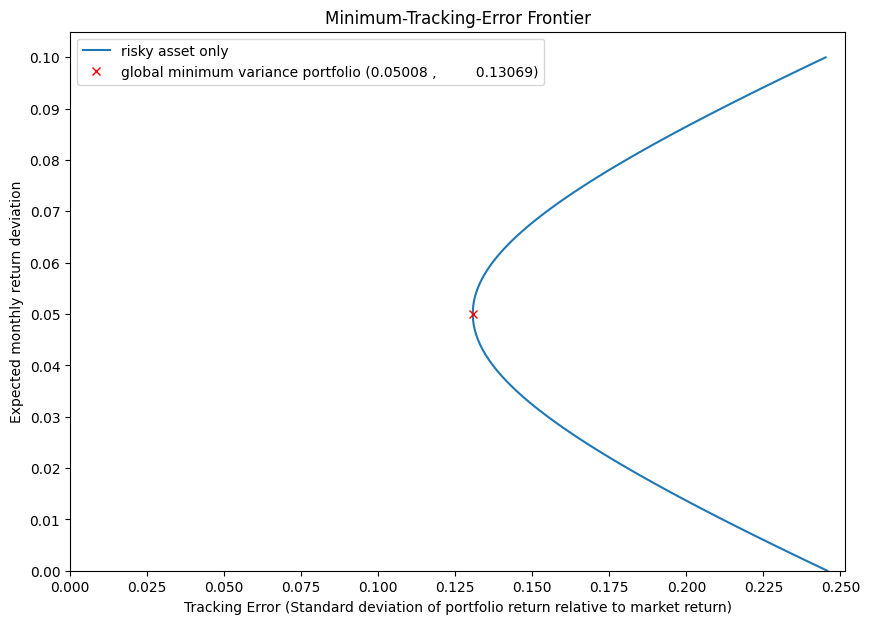

In [24]:
var_list = []
for x in possible_rp :
    var_list.append(newmva.var_mva(x))
f1, ax1 = plt.subplots(1)
f1.set_figheight(7)
f1.set_figwidth(10)
ax1.plot(np.sqrt(var_list), possible_rp,label = "risky asset only")
ax1.plot(np.sqrt(newmva.var_mva(newmva.R_mv)),newmva.R_mv,'rx',\
         label = f"global minimum variance portfolio ({newmva.R_mv:.5f} ,\
         {np.sqrt(newmva.var_mva(newmva.R_mv)):.5f})")
ax1.set_ylim(ymin=0)
ax1.set_xlim(xmin=0)
ax1.set_xlabel("Tracking Error (Standard deviation of portfolio return relative to market return)")
ax1.set_ylabel("Expected monthly return deviation")
ax1.xaxis.set_major_locator(plt.MultipleLocator(0.025))
ax1.set_title("Minimum-Tracking-Error Frontier")
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.01))
#ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f %%"))
ax1.legend()
plt.show(f1)
f1.savefig('f1.jpg')

## 2. Briefly explain the economic significance and relevance of the efficient frontier to an investor. ##
* The upper half of the minimum-variance frontier curve relative to the global minimum variance portfolio point is known as the efficient frontier. 
* A risk-averse investor should choose to invest in portfolios that lie on the efficient frontier because it gives the highest expected return for a specific risk compared to choosing the portfolio that lies on the lower half of the minimum-variance frontier curve 

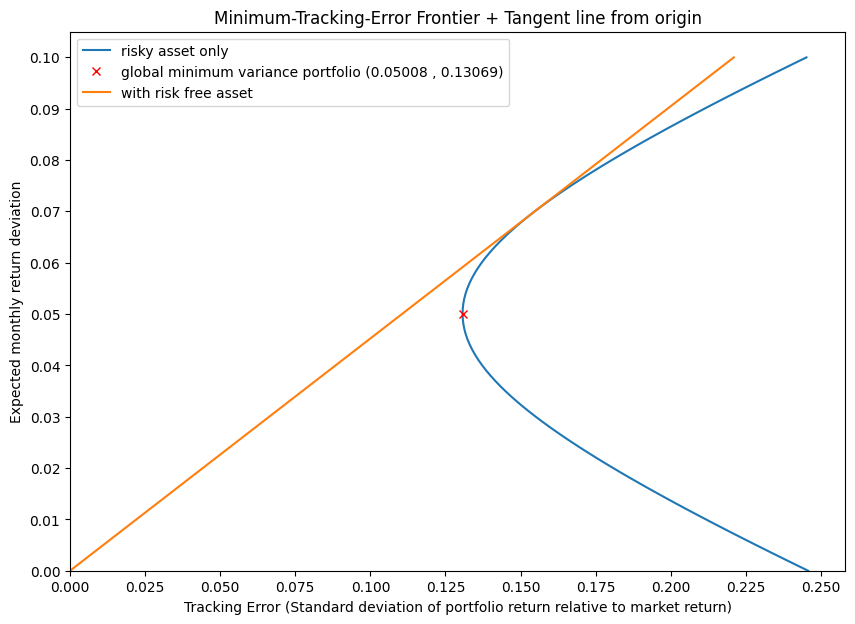

In [25]:
rf = 0
var_list_riskfree = []
for x in possible_rp :
    var_list_riskfree.append(newmva.var_mva_with_riskfree(x,rf))
f2, ax2 = plt.subplots(1)
f2.set_figheight(7)
f2.set_figwidth(10)
ax2.plot(np.sqrt(var_list), possible_rp,label = "risky asset only")
ax2.plot(np.sqrt(newmva.var_mva(newmva.R_mv)),newmva.R_mv,'rx',\
         label = f"global minimum variance portfolio ({newmva.R_mv:.5f} , {np.sqrt(newmva.var_mva(newmva.R_mv)):.5f})")
ax2.plot(np.abs(np.sqrt(var_list_riskfree)), possible_rp, label = "with risk free asset")
ax2.set_ylim(ymin=0)
ax2.set_xlim(xmin=0)
ax2.set_xlabel("Tracking Error (Standard deviation of portfolio return relative to market return)")
ax2.set_ylabel("Expected monthly return deviation")
ax2.xaxis.set_major_locator(plt.MultipleLocator(0.025))
ax2.set_title("Minimum-Tracking-Error Frontier + Tangent line from origin")
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax2.legend()
plt.show(f2)
f2.savefig('f2.jpg')

## 3. Briefly explain the economic significance and relevance of the tangency portfolio to an investor. ##
* When the a riskfree asset is included to the portfolio, the efficient frontier becomes a straight line which is tangent to the hyperbola curve at ($R_{tg}, \sigma_{tg}$). Another name for this line is the **Capital Market Portfolio**
* This efficient frontier line also intersects the Y axis at $R_f$ when a riskfree asset is included. This is to signify the inclusion of a riskfree asset (e.g. bonds, deposits) with return $R_f$ and 0 standard deviation (hence risk free)
* If the risk free rate is lower than global minimum variance return ($R_f < R_{mv}$), then the tangency portfolio is the point that offers the highest risk to reward ratio as the slope of the line (also known as the **sharpe ratio**) is the highest.
* For risk-averse investors who chose to incorporate a risk free asset into their portfolio, choosing to invest in the tangent portfolio means putting 100% of their wealth in risky assets.
* For this scenario, if an investor chooses to invest in portfolios

In [12]:
#tangent_portfolio = newmva.tangent_portfolio(possible_rp,0.0)


In [13]:
tangent_portfolio = newmva.tangent_portfolio(possible_rp,0)
tangent_portfolio.pop('tangent_weights')
tangent_info  = pd.DataFrame.from_dict(tangent_portfolio, orient ='index').rename(index={'return_var_ratio': 'information_ratio'})
latex_table = print(tangent_info.to_latex(index=True))


\begin{tabular}{lr}
\toprule
 & 0 \\
\midrule
return & 0.069828 \\
var & 0.023815 \\
std_dev & 0.154321 \\
information_ratio & 0.452488 \\
\bottomrule
\end{tabular}



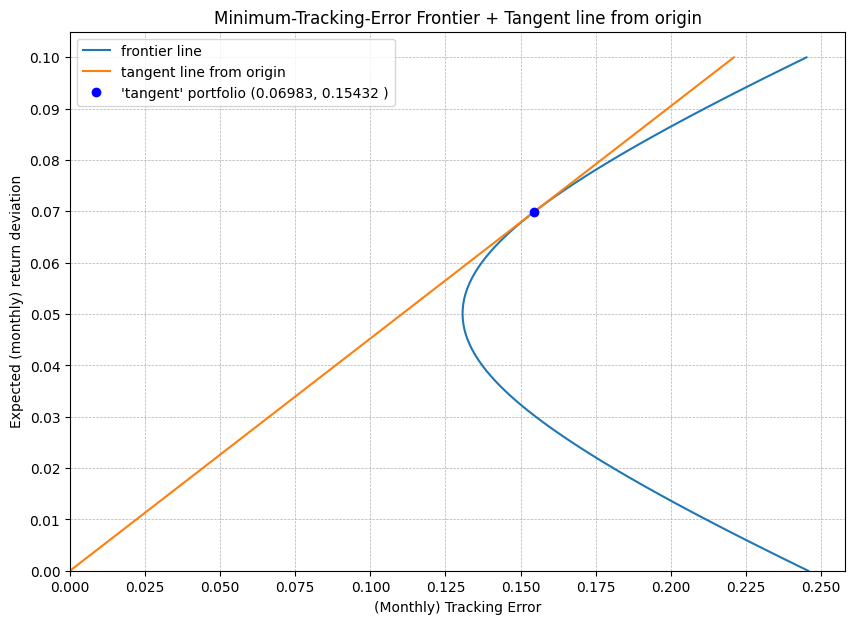

In [26]:
rf = 0
var_list_riskfree = []
for x in possible_rp :
    var_list_riskfree.append(newmva.var_mva_with_riskfree(x,rf))
    
f3, ax3 = plt.subplots(1)
f3.set_figheight(7)
f3.set_figwidth(10)
ax3.plot(np.sqrt(var_list), possible_rp,label = "frontier line")
#ax3.plot(np.sqrt(newmva.var_mva(newmva.R_mv)),newmva.R_mv,'rx',\
#         label = f"global minimum variance portfolio ({np.sqrt(newmva.var_mva(newmva.R_mv)):.5f}, {newmva.R_mv:.5f} )")
ax3.plot(np.sqrt(var_list_riskfree), possible_rp, label = "tangent line from origin")
ax3.plot(tangent_portfolio['std_dev'],tangent_portfolio['return'],'bo', \
         label = f"'tangent' portfolio ({tangent_portfolio['return']:.5f}, {tangent_portfolio['std_dev']:.5f} )")
ax3.set_ylim(ymin=0)
ax3.set_xlim(xmin=0)
ax3.set_xlabel("(Monthly) Tracking Error")
ax3.set_ylabel("Expected (monthly) return deviation (\)")
ax3.xaxis.set_major_locator(plt.MultipleLocator(0.025))
ax3.set_title("Minimum-Tracking-Error Frontier + Tangent line from origin")
#ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f %%"))
ax3.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax3.grid(linestyle = '--', linewidth = 0.5)
ax3.legend()
plt.show(f3)
f3.savefig('f3.jpg')

In [77]:
tangent_portfolio_weights_df = pd.concat( [pd.Series(resultdf.index), pd.Series(tangent_portfolio['tangent_weights'])],axis = 1)\
    .rename(columns = {0:'Industries',1:'Weight'})

KeyError: 'tangent_weights'

In [78]:
tangent_portfolio_weights_df
latex_table = print(tangent_portfolio_weights_df.to_latex(index=False))

NameError: name 'tangent_portfolio_weights_df' is not defined

In [79]:
vars(newmva)

{'R': array([ 0.15475   , -0.01475   ,  0.26475   ,  0.48308333,  0.01816667,
         0.13333333,  0.16825   ,  0.03575   ,  0.15908333, -0.259     ]),
 'V': array([[ 5.43969574, -6.07303523, -1.39619166, -1.20053326, -1.88315088,
          1.53888487,  1.14074116,  3.81513716,  4.27200187, -1.7687384 ],
        [-6.07303523, 26.62890078,  4.90802359, -3.48105498,  1.89157693,
         -1.70762521, -0.35433527, -8.08294641, -9.61749011,  4.38586529],
        [-1.39619166,  4.90802359,  2.9504991 ,  1.66613313,  0.06526676,
         -0.62641597, -1.15459666, -2.28889981, -1.90141158,  0.35890361],
        [-1.20053326, -3.48105498,  1.66613313, 19.27491058, -1.51697245,
         -1.04052465, -3.7104391 , -2.48579603,  4.4543684 , -3.8648258 ],
        [-1.88315088,  1.89157693,  0.06526676, -1.51697245,  5.09874619,
         -0.77329384, -0.24535029, -1.93628433, -2.34283867, -1.40405025],
        [ 1.53888487, -1.70762521, -0.62641597, -1.04052465, -0.77329384,
          4.68256695,  

## part 2 of the assignment ! ##

In [84]:
portfolio = concated_df[portfolio_cols]
portfolio_mean = portfolio.mean()
portfolio_std = portfolio.std()
portfolio_cov = portfolio.cov()

In [90]:
i = 0
mean_arr = []
stdev_arr = []
mean_inv_arr = []
stdev_inv_arr = []
while i < 10e5:
    #generate rand
    rand_weight = np.random.uniform(0,1,10)  
    inv_rand_weight =  np.reciprocal(rand_weight)

    #normalize with sum
    rand_weight = rand_weight/np.sum(rand_weight)
    inv_rand_weight = inv_rand_weight / np.sum(inv_rand_weight)

    #mutliply random weights with port mean (not portfolio excess !)
    rand_port = rand_weight * portfolio_mean
    inv_rand_port = inv_rand_weight * portfolio_mean

    #append mean points
    mean_arr.append(rand_port.sum())
    mean_inv_arr.append(inv_rand_port.sum())

    #append var points
    stdev_arr.append(np.sqrt(np.dot(np.dot(rand_weight.T,portfolio_cov),rand_weight)))
    stdev_inv_arr.append(np.sqrt(np.dot(np.dot(inv_rand_weight.T,portfolio_cov),inv_rand_weight)))

    i +=1


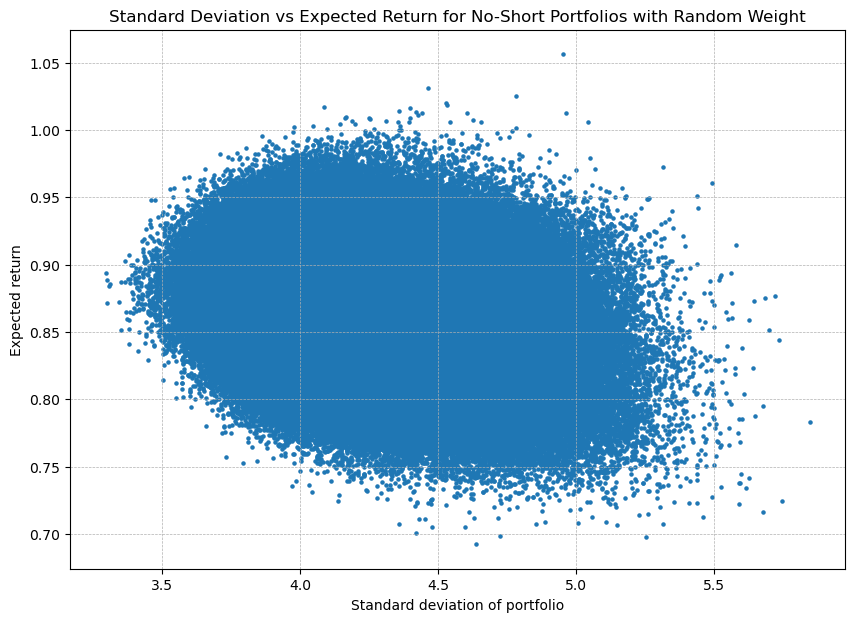

In [96]:
f4, ax4 = plt.subplots(1)
f4.set_figheight(7)
f4.set_figwidth(10)
ax4.scatter(stdev_arr,mean_arr,s=5)
ax4.set_xlabel("Standard deviation of portfolio")
ax4.set_ylabel("Expected return")
ax4.set_title("Standard Deviation vs Expected Return for No-Short Portfolios with Random Weight")
#ax4.xaxis.set_major_locator(plt.MultipleLocator(0.025))
#ax4.set_xlim(xmin=0)
ax4.grid(linestyle = '--', linewidth = 0.5)
f4.savefig('f4.jpg')

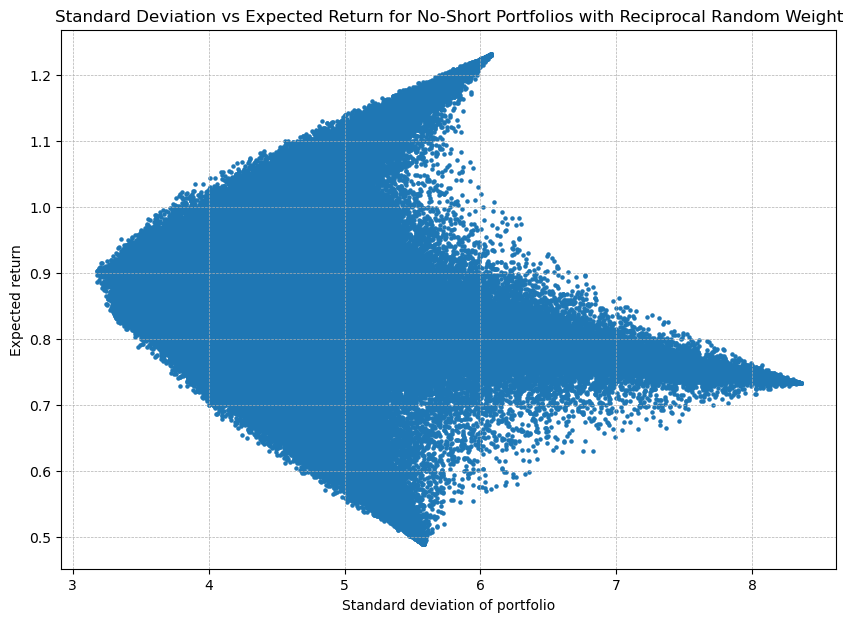

In [97]:
f5, ax5 = plt.subplots(1)
f5.set_figheight(7)
f5.set_figwidth(10)
ax5.scatter(stdev_inv_arr,mean_inv_arr,s=5)
ax5.set_xlabel("Standard deviation of portfolio")
ax5.set_ylabel("Expected return (%)")
ax5.set_title("Standard Deviation vs Expected Return for No-Short Portfolios with Reciprocal Random Weight")
#ax5.xaxis.set_major_locator(plt.MultipleLocator(0.025))
#ax5.set_xlim(xmin=0)
ax5.grid(linestyle = '--', linewidth = 0.5)
f5.savefig('f5.jpg')